# Guided Example: Data Set Generation + ANN Training/Testing
Accompanies Paper: Data Generation for Neural Programming by Example

Outline: Guide user through program generation, two I/O data generation methods, ANN training and plotting of top-k generalization across the two testing sets.

In [1]:
## Create a Data Set - up to all n=length line programs
import programGenerator as pg
import splitProgramsForTestAndTrain as split
import inputGenerator as genIO
import ann_utils as au
import numpy as np
import matplotlib.pyplot as plt

length = 2
outputFolder = './Progs'

generator = pg.programGenerator()
generator.getAllUpToMLines(length, outputFolder)

Using TensorFlow backend.


In [2]:
#Split programs into training/testing set, test fraction = 0.2
split.splitTrainAndTestRandom('./Progs/2Progs', 0.8)

In [3]:
#Generate IO via two different approaches, random exponential sampling, and Restricted Domain aka DeepCoder style
iogen = genIO.exampleGenerator()
trainingsetProgsName= './Progs/2Progs_training_0.8'
testsetProgsName= './Progs/2Progs_testing_0.2'
 
# Create Training Sets
with open(trainingsetProgsName+'.txt') as f:
    trainingSetProgs = f.readlines()

expsamp = iogen.factory(mode='exp', output_file_name=trainingsetProgsName+'_exp.txt', program_list = trainingSetProgs)
expsamp.run()
restricted = iogen.factory(mode='restricted', output_file_name=trainingsetProgsName+'_res.txt', program_list = trainingSetProgs)
restricted.run()

# Create Testing Sets
with open(testsetProgsName+'.txt') as f:
    testSetProgs = f.readlines()

expsamp = iogen.factory(mode='exp', output_file_name=testsetProgsName+'_exp.txt', program_list = testSetProgs)
expsamp.run()
restricted = iogen.factory(mode='restricted', output_file_name=testsetProgsName+'_res.txt', program_list = testSetProgs)
restricted.run()

In [2]:
#Generate IO via two different approaches, random exponential sampling, and Restricted Domain aka DeepCoder style
iogen = genIO.exampleGenerator()
trainingsetProgsName= './Progs/2Progs_training_0.8'
testsetProgsName= './Progs/2Progs_testing_0.2'
 
# Create Training Sets
with open(trainingsetProgsName+'.txt') as f:
    trainingSetProgs = f.readlines()

varied = iogen.factory(mode='varied', output_file_name=trainingsetProgsName+'_var.txt', program_list = trainingSetProgs)
varied.run()

In [5]:
# Prepare Training data in ANN ready format
# Learning is phrased as a multi-label classification problem, with the input being 5 examples of I/O pairs, and output being the presense or absence of elements of the DSL. 
paddingLength = 10
Ys_exp, ins_exp, outs_exp = au.readInForANN(trainingsetProgsName+'_exp.txt', paddingLength)
Ys_res, ins_res, outs_res = au.readInForANN(trainingsetProgsName+'_res.txt', paddingLength)
Ys_var, ins_var, outs_var = au.readInForANN(trainingsetProgsName+'_var.txt', paddingLength)

(4625, 34) (5, 4625, 23) (5, 4625, 23)
(4527, 34) (5, 4527, 23) (5, 4527, 23)
(4569, 34) (5, 4569, 23) (5, 4569, 23)


In [7]:
# Define and train ANNs on generated datasets (following DeepCoder setup)
embeddingDim = 20

# Model trained on Non-uniformily sampled data
model_exp = au.DeepCoderNN_shared(embeddingDim, ins_exp[0][0].size, Ys_exp[0].size, 'relu')

model_exp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mae'])
callback = [au.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')]

model_exp.fit([ins_exp[0], outs_exp[0], ins_exp[1], outs_exp[1], ins_exp[2],
              outs_exp[2], ins_exp[3], outs_exp[3], ins_exp[4], outs_exp[4]],
        Ys_exp, epochs=50, verbose=1, batch_size=128, validation_split=0.025, callbacks = callback)

# Model trained via 'Restricted Domain' procedure a la DeepCoder
model_res = au.DeepCoderNN_shared(embeddingDim, ins_res[0][0].size, Ys_res[0].size, 'relu')

model_res.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mae'])
model_res.fit([ins_res[0], outs_res[0], ins_res[1], outs_res[1], ins_res[2],
              outs_res[2], ins_res[3], outs_res[3], ins_res[4], outs_res[4]],
        Ys_res, epochs=50, verbose=1, batch_size=128, validation_split=0.025, callbacks = callback)

# Model trained via 'Varied' data
model_var = au.DeepCoderNN_shared(embeddingDim, ins_var[0][0].size, Ys_var[0].size, 'relu')

model_var.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mae'])
model_var.fit([ins_var[0], outs_var[0], ins_var[1], outs_var[1], ins_var[2],
              outs_var[2], ins_var[3], outs_var[3], ins_var[4], outs_var[4]],
        Ys_var, epochs=50, verbose=1, batch_size=128, validation_split=0.025, callbacks = callback)


Train on 4454 samples, validate on 115 samples
Epoch 1/50
4454/4454 [==============================] - 4s 815us/step - loss: 0.3852 - mean_absolute_error: 0.2387 - val_loss: 0.2799 - val_mean_absolute_error: 0.1474
Epoch 2/50
4454/4454 [==============================] - 2s 405us/step - loss: 0.2821 - mean_absolute_error: 0.1601 - val_loss: 0.2654 - val_mean_absolute_error: 0.1515
Epoch 3/50
4454/4454 [==============================] - 2s 381us/step - loss: 0.2751 - mean_absolute_error: 0.1557 - val_loss: 0.2457 - val_mean_absolute_error: 0.1403
Epoch 4/50
4454/4454 [==============================] - 2s 392us/step - loss: 0.2676 - mean_absolute_error: 0.1497 - val_loss: 0.2454 - val_mean_absolute_error: 0.1405
Epoch 5/50
4454/4454 [==============================] - 2s 431us/step - loss: 0.2591 - mean_absolute_error: 0.1463 - val_loss: 0.2492 - val_mean_absolute_error: 0.1362
Epoch 6/50
4454/4454 [==============================] - 2s 420us/step - loss: 0.2445 - mean_absolute_error: 0.139

In [8]:
# Calculate fraction of correct predictions on test set of new programs not seen in the training set - as well as on a different distribution of inputs
bl2, bl3, bl4 = np.load('Progs/2_3_4Progs_baselines.npy')
bl2 = [x[0] for x in bl2]

# Training set: NonUniform. Testing Set: NonUniform.
fl_e_e, ll_e_e, w_e_e, blf_e, bll_e, blw_e = au.calculateAccuracy(testsetProgsName+'_exp.txt', model_exp, bl2)
# Training set: NonUniform. Testing Set: Restricted Domain
fl_e_r, ll_e_r, w_e_r, blf_r, bll_r, blw_r = au.calculateAccuracy(testsetProgsName+'_res.txt', model_exp, bl2)
# Training set: Restricted Domain. Testing Set: NonUniform.
fl_r_e, ll_r_e, w_r_e, blf_e, bll_e, blw_e = au.calculateAccuracy(testsetProgsName+'_exp.txt', model_res, bl2)
# Training set: Restricted Domain. Testing Set: Restricted Domain
fl_r_r, ll_r_r, w_r_r, blf_r, bll_r, blw_r = au.calculateAccuracy(testsetProgsName+'_res.txt', model_res, bl2)

fl_v_e, ll_v_e, w_v_e, blf_e, bll_e, blw_e = au.calculateAccuracy(testsetProgsName+'_exp.txt', model_var, bl2)
# Training set: Restricted Domain. Testing Set: Restricted Domain
fl_v_r, ll_v_r, w_v_r, blf_r, bll_r, blw_r = au.calculateAccuracy(testsetProgsName+'_res.txt', model_var, bl2)

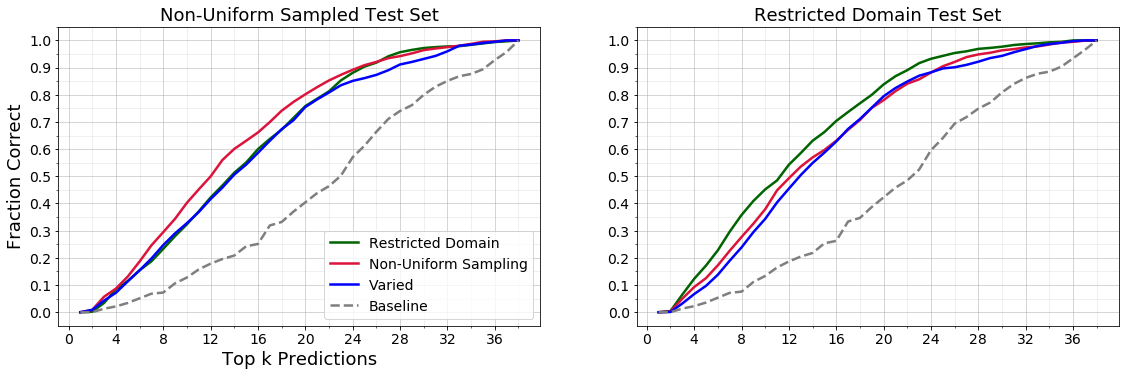

In [10]:
xaxis = np.arange(1,39)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(19,5.5))

axes[0].plot(xaxis,w_r_e, label = 'Restricted Domain', color = 'darkgreen',linewidth = 2.5)
axes[0].plot(xaxis,w_e_e, label = 'Non-Uniform Sampling', color = 'crimson',linewidth = 2.5)
axes[0].plot(xaxis,w_v_e, label = 'Varied', color = 'blue',linewidth = 2.5)

axes[0].plot(xaxis,blw_e,linewidth=2.5, color = 'tab:grey', label = 'Baseline', linestyle='--')
axes[0].set_title('Non-Uniform Sampled Test Set',fontsize =18)

axes[1].plot(xaxis,w_r_r, label = 'Restricted Domain', color = 'darkgreen',linewidth = 2.5)
axes[1].plot(xaxis,w_e_r, label = 'Non-Uniform Sampling', color = 'crimson',linewidth = 2.5)
axes[1].plot(xaxis,w_v_r, label = 'Varied', color = 'blue',linewidth = 2.5)

axes[1].plot(xaxis,blw_r,linewidth=2.5, color = 'tab:grey', label = 'Baseline', linestyle='--')
axes[1].set_title('Restricted Domain Test Set',fontsize =18)

# Major ticks every 20, minor ticks every 5
major_ticks = np.arange(0, 39, 4)
minor_ticks = np.arange(0, 39, 2)

major_ticksy = np.arange(0, 1.1, 0.1)
minor_ticksy = np.arange(0, 1.1, 0.05)

axes[0].set_xticks(major_ticks)
axes[0].set_xticks(minor_ticks, minor=True)
axes[0].set_yticks(major_ticksy)
axes[0].set_yticks(minor_ticksy, minor=True)
axes[0].xaxis.set_tick_params(labelsize=14)
axes[0].yaxis.set_tick_params(labelsize=14)

axes[1].set_xticks(major_ticks)
axes[1].set_xticks(minor_ticks, minor=True)
axes[1].set_yticks(major_ticksy)
axes[1].set_yticks(minor_ticksy, minor=True)
axes[1].xaxis.set_tick_params(labelsize=14)
axes[1].yaxis.set_tick_params(labelsize=14)

axes[0].legend(fontsize = 14)

axes[0].grid(which='minor', alpha=0.25)
axes[0].grid(which='major', alpha=0.5)
axes[1].grid(which='minor', alpha=0.25)
axes[1].grid(which='major', alpha=0.5)

axes[0].set_xlabel('Top k Predictions', fontsize = 18)
axes[0].set_ylabel('Fraction Correct',fontsize = 18)
plt.show()